# Learnability Project: PFA Phonotactic Learner

------

## General functions and other stuff

In [63]:
from pyfoma import FST, State

lam = "λ"


def data_iterator(path):
    """Yield a word as a list of tokens"""
    with open (path, "r") as fin:
        for line in fin.readlines():
            yield line.split()
            
            
def make_alphabet(path) -> list:
    """This function extracts an alphabet from a corpusl"""
    alph = []
    for word in data_iterator(path):
        for sym in word:
            if sym not in alph:
                alph.append(sym)
    return alph

def get_trans_sum(state):
    """sums all the transition weights (counts) and the finalweight for given state """
    return sum([tran.weight for _, tran in state.all_transitions()])
    

## Strictly 2-Local Functions

In [168]:
def make_SL2_dfa(alphabet:list) -> FST:
    """This function initializes a 2-SL PFA according to an alphabet. All weights are set to 0 by default"""
    
    # create the FST object and instantiate the initial state
    dfa = FST()
    q0 = dfa.initialstate
    q0.finalweight = 0
    q0.name = lam
    states = {q0,}
    
    # initialize all states and connect q0 to them
    for sym in alphabet:
        q = State()
        q.name = sym
        q0.add_transition(q, sym, 0)
        states.add(q)
        q.finalweight = 0
    
    # loopify the states, excluding q0
    states_no_q0 = set([s for s in states if s.name != lam])
    for state1 in states_no_q0:
        for state2 in states_no_q0:
            state1.add_transition(state2, state2.name, 0)
    
    dfa.states      = states
    dfa.finalstates = states
    dfa.alphabet    = alphabet
    return dfa

def update_SL(dfa:FST, path:str) -> FST:
    """
    This function takes a 2SL dfa and updates each transition whenever it is "passed through".
    
    More specifically, for each word, it iterates over the outgoing transitions for each state, checks which transition label
    matches the current token in the word, and then increments that transition's weight by 1.
    
    Each time a string ends in a state, that state's `finalweight` attribute is also incremented by 1.
    """
    for word in data_iterator(path):
        cs = dfa.initialstate # gets set back to q0 when a new word is processed
        for token in word:
            for _, trans in cs.all_transitions():
                
                if trans.label == token: # find the transition that matches the current token
                    trans.weight += 1
                    cs = trans.targetstate # update cs to transition's target state. This is how we "traverse" the states
                    
        cs.finalweight += 1 # update the weight of the last state the current string ends in
    return dfa

def MLE_SL(dfa:FST, path:str) -> FST:
    """This function takes a SL DFA, updates its weights from a corpus, and normalizes"""
    dfa = update_SL(dfa, path)
    
    #  list of state weight sums 
    all_state_trans_sums = [get_trans_sum(state) + state.finalweight for state in dfa.states] 
    
    for i, state in enumerate(dfa.states):
        for _, trans in state.all_transitions():
            
            #  normalize transition weight by sum of the state's transition weights
            trans.weight = (trans.weight) / all_state_trans_sums[i]
            
        state.finalweight = (state.finalweight / all_state_trans_sums[i])

    # assert that each state's transition weights sum to 1
    for state in dfa.states:
        try:
            total = sum([t.weight for _, t in state.all_transitions()]) + state.finalweight
            assert total > .99 # accounts for floating point precision
        except AssertionError:
            print(f"State: {state.name} is misbehaving!\nWeighted sum: {total} != 1\n")
            raise RuntimeError
            

    return dfa


## Strictly 2-Piecewise Functions

In [192]:
def make_SP2_dfas(alphabet:list) -> list[FST]:
    """This function intitializes 2SP machines according the length of the alphabet"""
    SP2_machines = []
    
    # initializes all 2 state machines and loopify them
    for sym1 in alphabet:
        dfa             = FST()
        q0              = dfa.initialstate
        q0.finalweight  = 0
        q0.name         = lam
        q1              = State()
        q1.finalweight  = 0
        q1.name         = sym1
        dfa.states      = {q0, q1}
        dfa.finalstates = {q0, q1}
        dfa.alphabet    = alphabet
        q0.add_transition(q1, sym1, 0)
        
        # loopification
        for sym2 in alphabet:
            if sym1 != sym2:
                q0.add_transition(q0, sym2, 0)
            
            q1.add_transition(q1, sym2, 0)
        
        SP2_machines.append(dfa)
     
    return SP2_machines

            
        
def update_SP(dfas:list[FST], path:str) -> list[FST]:
    
    # pass each word from corpus through all dfas and increment weights accordingly
    for word in data_iterator(path):
        for dfa in dfas:
            
            cs = dfa.initialstate
            for token in word:
                for _, trans in cs.all_transitions():
                    
                    # detect if transition brings us into new state
                    if token == trans.targetstate.name: 
                        cs = trans.targetstate
                        
                    if trans.label == token:
                        trans.weight += 1


            
        #cs.finalweight += 1
                        
    return dfas
        
        
        
        
def MLE_SP(dfas:list[FST], path:str) -> list[FST]:
    
    dfas = update_SP(dfas, path)
    
    return dfas


## Playground

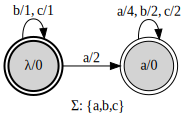

In [205]:
# Learning data paths
debug   = "data/eric_debugging_data.txt"
toy     = "data/LearningData.txt"
navajo  = "data/LearningData_navajo.txt"
quechua = "data/LearningData_quechua.txt"

toy_alph = make_alphabet(toy)
debug_alph = make_alphabet(debug)

db_SL2     = make_SL2_dfa(debug_alph)
db_SL2_MLE = MLE_SL(db_SL2, debug)


db_SP2     = make_SP2_dfas(debug_alph)
db_SP2_MLE = MLE_SP(db_SP2, debug)

db_SP2_MLE[0].view()



sum log probs along path given string



1